In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics
from collections import defaultdict 

import matsim

In [2]:
## Adapted from Théo's code

def parse_attributes(node):
    values=[subnode.text for subnode in node.findall("attribute")]
    attributes=[subnode.attrib["name"] for subnode in node.findall("attribute")]
    person=dict()
    for ii in range(len(values)):
        person[attributes[ii]]=values[ii]
    if person!=[None]:
        return(person)
    
def parse_person(node):
    person = parse_attributes(node.find("attributes"))
    person["id"] = node.attrib["id"]
    return(person)

def parse_plan(node):
    children = list(node)
    plan={"selected":node.attrib["selected"]=="yes","activities":[{**{"activityType":child.tag}, **child.attrib} for child in children]}
    return plan

def parse_person_plan(node):
    # on récupère les plans sélectionnés
    plans = [parse_plan(plan) for plan in node.findall("plan") if plan.attrib["selected"]=="yes"]
    personId = node.attrib["id"]
    if len(plans)!=1:
        raise Exception("La personne d'id "+str(personId)+" a plusieurs plans sélectionnés !")
    else:
        plan={"personId":personId,"activities":plans[0]["activities"]}
        return(plan)

def parse_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person(node) for node in population.findall("person")]
    
def parse_plans_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person_plan(node) for node in population.findall("person")]

def select_first_coordinate_in_plan(person_plan):
    """A partir du plan d'une personne, remonte à ces premières coordonnées
    Renvoie un dict {personId,x,y}"""
    plan=person_plan["activities"]
    coordinates_found=False
    first_coordinates={"personId":person_plan["personId"]}
    for acti in plan:
        if "x" in acti:
            coordinates_found=True
            first_coordinates["x"]=acti["x"]
            first_coordinates["y"]=acti["y"]
            break
    if not coordinates_found:
        raise Exception("La personne "+str(person_plan["personId"])+" n'a pas de coordonnées définissables avec son plan d'activité.")
    else:
        return(first_coordinates)

def first_person_coordinates(path):
    with open(path, 'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        first_coordinates=[select_first_coordinate_in_plan(parse_person_plan(node)) for node in population.findall("person")]
        return(first_coordinates)

def population_stats(population):
    number=len(population)
    print("Taille population:   ",number)
    print("Titulaires du permis:",len([person for person in population if person["hasLicense"]=="yes"]))
    print("Femmes:              ",len([person for person in population if person["sex"]=="f"]))
    print("Hommes:              ",len([person for person in population if person["sex"]=="m"]))
    print("Revenu moyen:        ",statistics.mean([float(person["householdIncome"]) for person in population]))
    print("Abonnés aux pt:      ",len([person for person in population if person["hasPtSubscription"].lower()=="true"]))
    #return members
    #CSMembership(members,companies,CSMembership_file

In [3]:
def convert_time(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0])

def convert_time_h_m_s(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0, 1.0])

# Performance criteria [1]

In both non-shared and shared taxi services, the average customer wait (including boarding) time $T^W$ and the 95th percentile $T_{95}^w$, the average ride (i.e. on board or in-vehicle travel) time $T^R$, the fleet-wide ratio of empty-to-total mileage $e^D $, the rate of request rejection $ρ$ are key performance indicators.


In addition to that, the revenue kilometers $d^U$ per overall driven distance $d^T$ , $U^d$= $d^U$/$d^T$, is of relevance. 

This value may be interpreted as an indicator for fleet utilization, with a higher value indicating a higher vehicle occupancy. 
However, it needs to be taken with care, since also extreme detours result in a high utilization, as long as there are passengers on board the vehicle. 
This may not be necessarily beneficial for operators, who tend to charge flat fees based on direct trip distances.
To accommodate for this, we introduce another fleet-wide indicator which takes into account the overall driven distance to the total mileage requested by customers: 

$\lambda = \dfrac{d^T}{\sum_{r\in N} d^{direct}_r}$


where $d^{direct}_r$ is the direct distance between the origin and r destination of request $r$.

For **non-shared taxi**, $1/\lambda = 1 − e^D$ and thus λ is always greater than 1 as vehicles have empty drives between requests.
It can be $1$ for a **single-person private car trip**, as long as no detours are made, e.g. for parking search (which may account to $20%$ of additional traffic in residential city areas).

For **shared rides**, however, $\lambda< 1$ is feasible and should be targeted, especially when focusing on providing sustainable transport services. 
This allows operators to claim their service to be more efficient than private cars.

[1] Bischoff, J., Maciejewski, M., & Nagel, K. (2017, October). City-wide shared taxis: A simulation study in Berlin. In 2017 IEEE 20th international conference on intelligent transportation systems (ITSC) (pp. 275-280). IEEE.

In [4]:
output_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario3_v2_15_p_cent_2000_ite" 

## Scenario description (Pooled shared autonomous vehicle (PSAV))
- Remplacement des voitures privées des individus par des robotaxis partagés.
- Taille de la flotte de taxis 3869 avec un taxi pour 10 voitures privées.
- Démotorisation (surpression de la voiture) des ménages résidant dans des zones denses (Lyon, Villeurbanne, Bron, Vaulx-en-Velin et Caluire-et-Cuire).
- Les individus dans les zones périphériques concervent leurs voitures.
- Possibilité d'avoir plusieurs passagers dans le taxi.

In [5]:
input_trips_file = "%s/df_trips_input_plans_sce3.csv" %output_path
input_persons_file = "%s/df_persons_input_perons_sce3.csv" %output_path
df_persons_input = pd.read_csv(input_persons_file)
df_trips_input = pd.read_csv(input_trips_file)

In [6]:
df_persons_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63170 entries, 0 to 63169
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         63170 non-null  int64  
 1   age                63170 non-null  int64  
 2   bikeAvailability   63170 non-null  object 
 3   carAvailability    63170 non-null  object 
 4   censusHouseholdId  63170 non-null  int64  
 5   censusPersonId     63170 non-null  int64  
 6   employed           63170 non-null  bool   
 7   hasLicense         63170 non-null  object 
 8   hasPtSubscription  63170 non-null  bool   
 9   householdId        63170 non-null  int64  
 10  householdIncome    63170 non-null  float64
 11  htsHouseholdId     63170 non-null  int64  
 12  htsPersonId        63170 non-null  int64  
 13  isPassenger        63170 non-null  bool   
 14  sex                63170 non-null  object 
 15  subpopulation      63170 non-null  object 
 16  person_id          631

In [7]:
df_trips_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354575 entries, 0 to 354574
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    354575 non-null  int64  
 1   person_id                     354575 non-null  int64  
 2   departure_time                354575 non-null  object 
 3   arrival_time                  354575 non-null  object 
 4   mode                          354575 non-null  object 
 5   preceding_purpose             354575 non-null  object 
 6   from_x                        354575 non-null  float64
 7   from_y                        354575 non-null  float64
 8   preceding_purpose_start_time  167835 non-null  object 
 9   preceding_purpose_end_time    231005 non-null  object 
 10  following_purpose             354575 non-null  object 
 11  to_x                          354575 non-null  float64
 12  to_y                          354575 non-nul

In [8]:
df_count_trips = df_trips_input[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [9]:
df_persons_input = pd.merge(df_persons_input, df_count_trips, on = "person_id", how = "left")

In [10]:
df_count_persons = df_persons_input[["householdId"]].groupby("householdId").size().reset_index(name = "number_of_persons")

In [11]:
df_persons_input = pd.merge(df_persons_input, df_count_persons, on = "householdId", how = "left")

In [12]:
f = (df_persons_input["subpopulation"]=="urban_motorized") | (df_persons_input["subpopulation"]=="urban_no_motorized")
df_urban_persons_input = df_persons_input[f]

In [13]:
df_urban_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips,number_of_persons
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008,7,3
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009,4,3
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010,11,3
8,8,54,none,none,18481,38076,True,yes,False,47646,2500.599827,7025,15321,False,f,urban_motorized,100008,17,3
9,9,20,none,none,183028,378014,False,no,True,474474,2529.986265,9129,19881,False,f,urban_no_motorized,1000087,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63159,63159,40,all,none,18475,38061,True,no,True,47634,889.768051,9543,20837,False,m,urban_no_motorized,99976,12,1
63160,63160,81,none,none,182968,377908,False,no,True,474316,765.679986,4904,10784,False,f,urban_no_motorized,999796,12,1
63161,63161,46,none,none,182977,377929,True,yes,False,474345,1144.158965,8955,19509,False,m,urban_motorized,999871,2,1
63164,63164,66,none,none,182997,377959,True,yes,True,474396,3022.192917,801,1776,False,f,urban_motorized,999946,8,2


In [14]:
df_count_urban_persons = df_urban_persons_input[["householdId"]].groupby("householdId").size().reset_index(name = "number_of_persons")

In [15]:
df_count_urban_persons

,householdId,number_of_persons
0,23,2
1,81,1
2,120,2
3,134,2
4,141,1
...,...,...
20329,614521,1
20330,614542,1
20331,614607,1
20332,614610,1


In [16]:
df_count_urban_persons.describe()

,householdId,number_of_persons
count,20334.000000,20334.000000
mean,306483.816662,1.902921
std,177859.027520,1.226488
min,23.000000,1.000000
25%,152885.750000,1.000000
50%,304607.000000,1.000000
75%,462775.000000,2.000000
max,614745.000000,9.000000


In [17]:
count_urban_persons = df_count_urban_persons["number_of_persons"].value_counts(normalize=True) * 100

In [18]:
count_urban_persons

1    51.701584
2    25.700797
3     9.958690
4     7.903020
5     3.211370
6     1.160618
7     0.260647
8     0.073768
9     0.029507
Name: number_of_persons, dtype: float64

<AxesSubplot:>

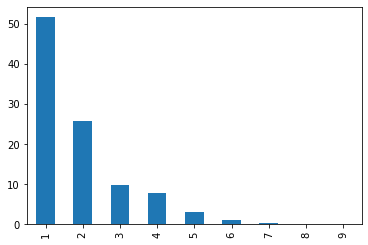

In [19]:
count_urban_persons.plot(kind="bar")

In [20]:
df_urban_persons_input["number_of_trips"].describe()

count    38694.000000
mean         5.818809
std          4.104591
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         43.000000
Name: number_of_trips, dtype: float64

In [21]:
count_trips = df_urban_persons_input["number_of_trips"].value_counts(normalize=True) * 100

In [22]:
count_trips

2     25.929085
4     18.977102
6     13.190676
8      6.719388
3      6.019021
5      5.225616
10     5.212694
12     3.884323
7      3.545769
9      2.155373
14     1.780638
11     1.617822
13     1.237918
16     1.230165
15     0.749470
17     0.470357
18     0.449682
20     0.397995
1      0.330801
19     0.222257
21     0.136972
22     0.129219
23     0.100791
24     0.072363
26     0.067194
25     0.051688
30     0.020675
27     0.018091
28     0.018091
31     0.012922
32     0.007753
35     0.005169
34     0.002584
43     0.002584
33     0.002584
29     0.002584
42     0.002584
Name: number_of_trips, dtype: float64

<AxesSubplot:>

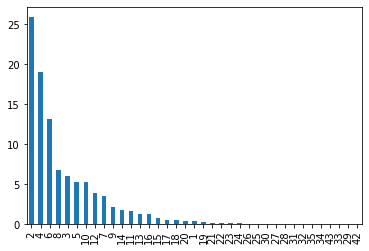

In [23]:
count_trips.plot(kind="bar")

### parts modales (input)

In [24]:
modal_share_inp = df_trips_input["mode"].value_counts(normalize=True) * 100

In [25]:
modal_share_inp

walk             57.289431
pt               17.425086
drt              10.374956
car               9.824156
car_passenger     3.693718
bike              1.392653
Name: mode, dtype: float64

Text(0.5, 0, 'Mode de transport')

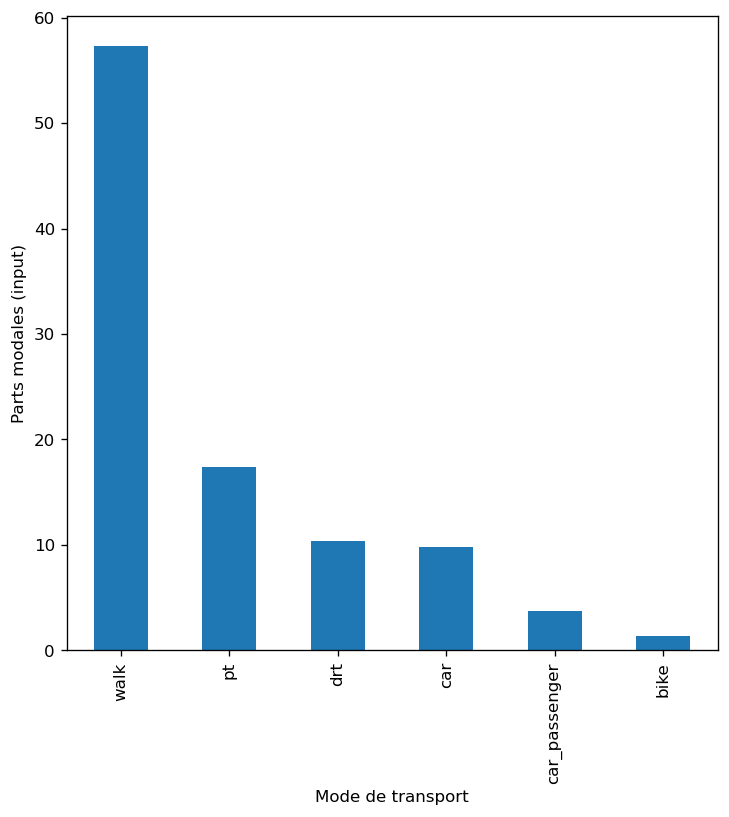

In [26]:
plt.figure(figsize = (7, 7), dpi = 120)
modal_share_inp.plot(kind="bar")
plt.ylabel("Parts modales (input)")
plt.xlabel("Mode de transport")

In [27]:
time_class = np.arange(0, 30) * 3600

In [28]:
df_trips_input["dep_time_in_s"] = df_trips_input["departure_time"].apply(convert_time_h_m_s).astype(float)

In [29]:
df_trips_input["dep_time_class"] = np.digitize(df_trips_input["dep_time_in_s"], time_class)

In [30]:
f_drt = df_trips_input["mode"] == "drt"

In [31]:
df_trips_input_drt = df_trips_input[f_drt]

In [32]:
print("Nombre total de déplacements en DRT : ", len(df_trips_input_drt))

Nombre total de déplacements en DRT :  36787


Text(0.5, 0, 'Time of day [h]')

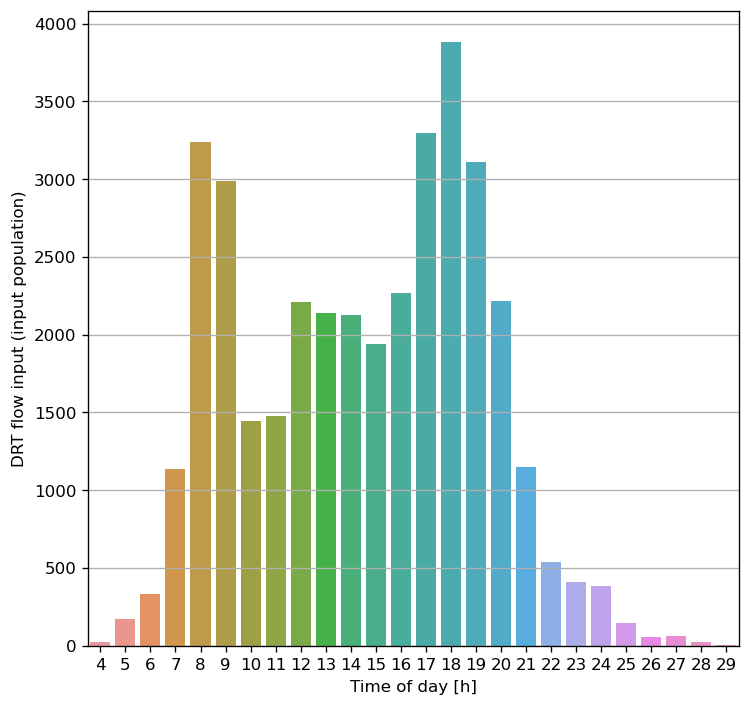

In [33]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input_drt)
ax.grid(axis='y')
plt.ylabel("DRT flow input (input population)")
plt.xlabel("Time of day [h]")

In [34]:
df_trips_input_drt["dep_time_class"].value_counts()

18    3884
17    3298
8     3239
19    3113
9     2990
16    2265
20    2218
12    2208
13    2142
14    2127
15    1940
11    1480
10    1444
21    1148
7     1137
22     540
23     412
24     385
6      331
5      171
25     144
27      62
26      58
4       25
28      22
29       4
Name: dep_time_class, dtype: int64

In [35]:
count_trips_drt_h = df_trips_input_drt["dep_time_class"].value_counts(normalize=True) * 100

In [36]:
count_trips_drt_h

18    10.558078
17     8.965124
8      8.804741
19     8.462229
9      8.127871
16     6.157066
20     6.029304
12     6.002120
13     5.822709
14     5.781934
15     5.273602
11     4.023160
10     3.925300
21     3.120668
7      3.090766
22     1.467910
23     1.119961
24     1.046565
6      0.899774
5      0.464838
25     0.391443
27     0.168538
26     0.157664
4      0.067959
28     0.059804
29     0.010873
Name: dep_time_class, dtype: float64

Text(0.5, 0, 'Trip purposes')

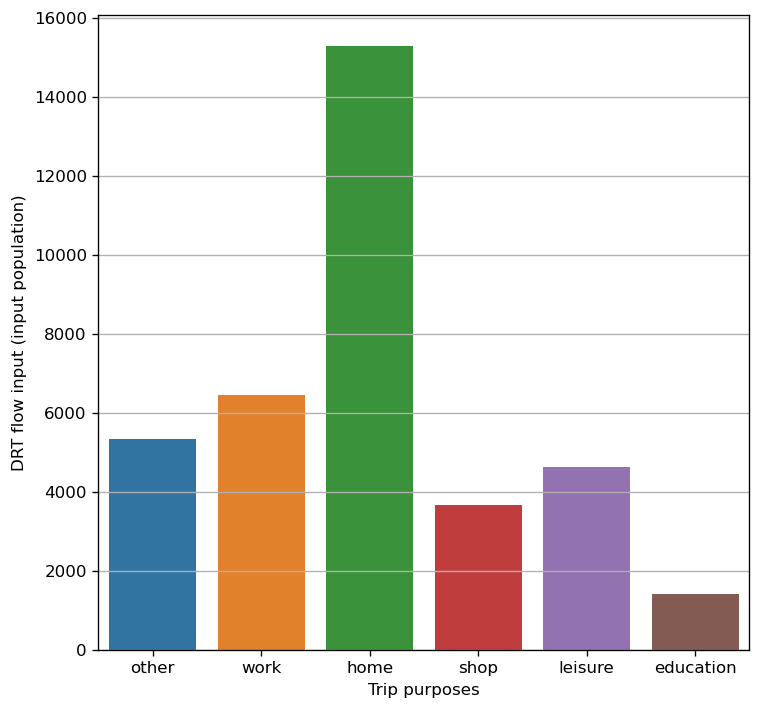

In [37]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_drt)
ax.grid(axis='y')
plt.ylabel("DRT flow input (input population)")
plt.xlabel("Trip purposes")

In [38]:
f_matin = df_trips_input_drt["dep_time_class"] == 8
f_matin |= df_trips_input_drt["dep_time_class"] == 9

f_midi = df_trips_input_drt["dep_time_class"] == 12
f_midi |= df_trips_input_drt["dep_time_class"] == 13
f_midi |= df_trips_input_drt["dep_time_class"] == 14

f_soir = df_trips_input_drt["dep_time_class"] == 17
f_soir |= df_trips_input_drt["dep_time_class"] == 18
f_soir |= df_trips_input_drt["dep_time_class"] == 19

Text(0.5, 0, 'Trip purposes from 8h to 9h')

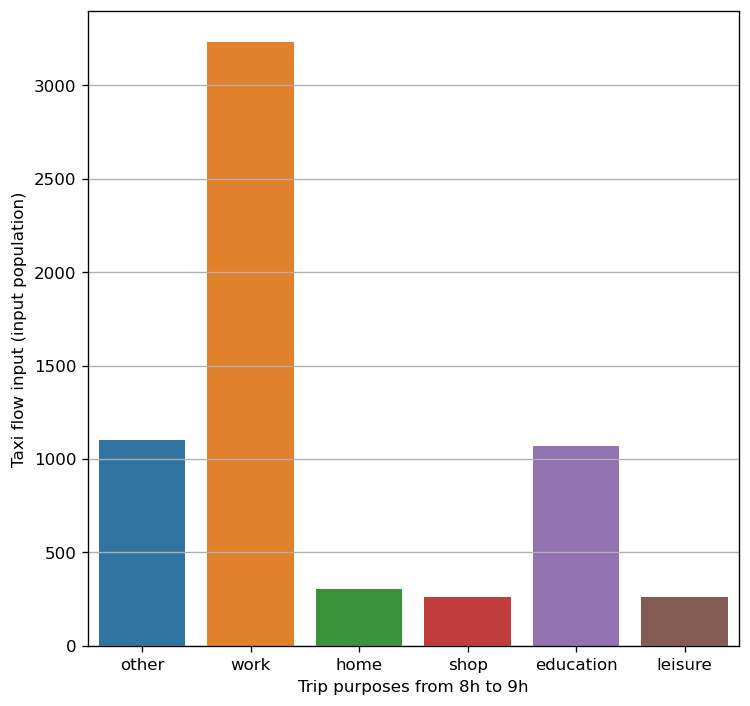

In [39]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_drt[f_matin])
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Trip purposes from 8h to 9h")

In [40]:
df_trips_input_drt[f_matin]["following_purpose"].value_counts(normalize=True) * 100

work         51.918446
other        17.643281
education    17.193771
home          4.896452
leisure       4.206133
shop          4.141917
Name: following_purpose, dtype: float64

Text(0.5, 0, 'Trip purposes from 12h to 14h')

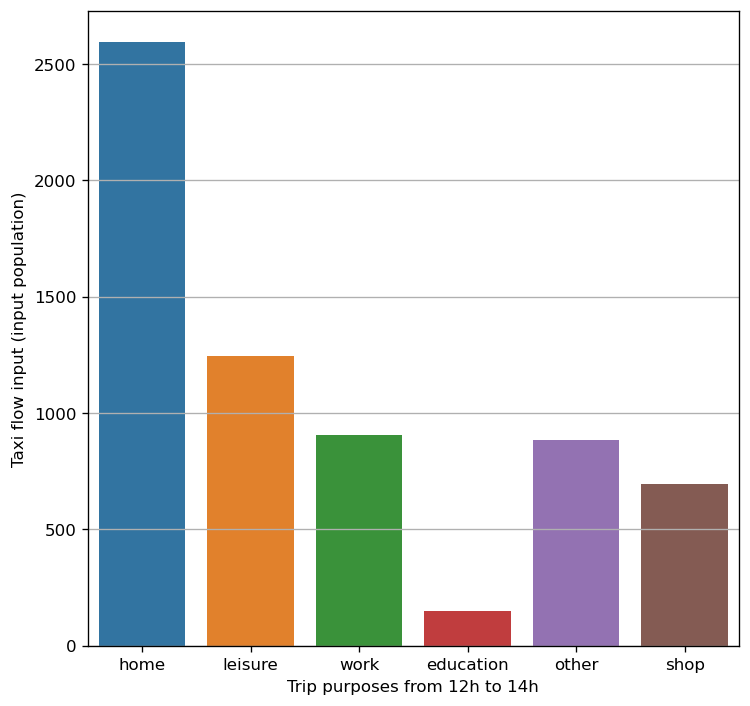

In [41]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_drt[f_midi])
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Trip purposes from 12h to 14h")

In [42]:
df_trips_input_drt[f_midi]["following_purpose"].value_counts(normalize=True) * 100

home         40.080284
leisure      19.190983
work         14.003397
other        13.663733
shop         10.730276
education     2.331326
Name: following_purpose, dtype: float64

Text(0.5, 0, 'Trip purposes from 17h to 19h')

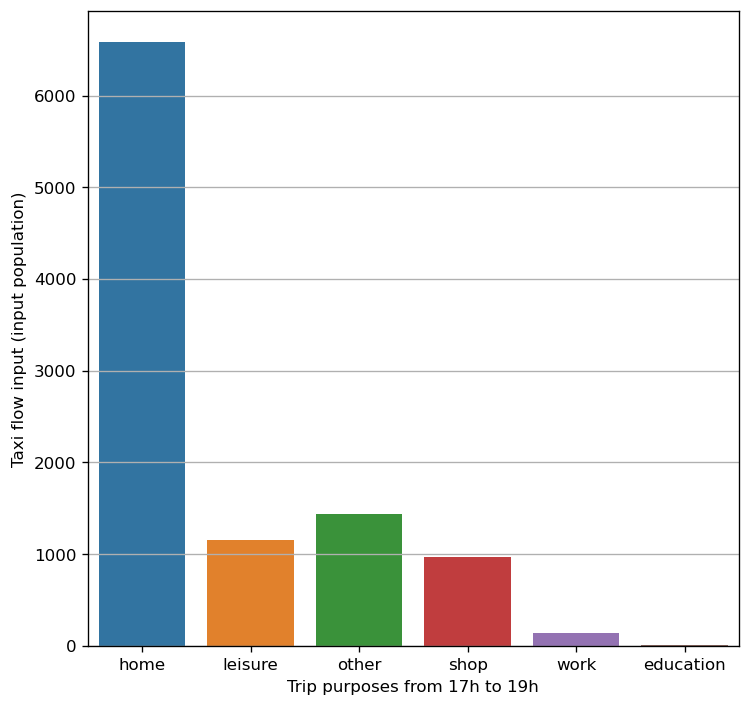

In [43]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_drt[f_soir])
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Trip purposes from 17h to 19h")

In [44]:
df_trips_input_drt[f_soir]["following_purpose"].value_counts(normalize=True) * 100

home         63.992229
other        13.909665
leisure      11.238465
shop          9.402623
work          1.359883
education     0.097135
Name: following_purpose, dtype: float64

## Description de la population

- $\mathbf{5\%}$ de la population réelle ($\mathbf{30900}$ ménages /$\mathbf{63 110}$ ind. / $\mathbf{310 000}$ dép.)
- 

## Configuration de la simulation

- $\mathbf{2000}$ itérations / simulation (arret de l'innovation à $\mathbf{75\%}$)
- Strategies de re-planification :
    - $\mathbf{5}$ plans max / agent
    - Chaque agent change, avec une probalité de $\mathbf{5\%}$, son itinéraire et le planning de ses activités (heure de fin). La probabilité du changement du mode de transport a été fixée à $\mathbf{10\%}$ pour accelerer la convergernce de la simulation.
    - Le changement de modes de transport pour les individus dans les zones urbaines concerne uniquement les **TC, le DRT, le vélo, et la marche à pied**. Pour les agents dans les quartiers periphériques, le choix se fait entre les **TC, la voiture, le vélo, et la marche à pied**.
    - Chaque agent choisi un plan parmi les $5$ selon un modèle logit avec une probalité de $\mathbf{80\%}$.

## Analyse des resultats de la simulation

In [45]:
##Case 1 : with 1917 taxis
task_time_profiles_drt_file = "%s/ITERS/it.2000/sce3.v2.2000.task_time_profiles_drt.txt" %output_path
df_task_time_profiles_drt = pd.read_csv(task_time_profiles_drt_file, sep="	")

In [46]:
df_task_time_profiles_drt

,time,STAY,DRIVE,STOP
0,00:00,1916.0,0.0,0.0
1,00:05,1916.0,0.0,0.0
2,00:10,1916.0,0.0,0.0
3,00:15,1916.0,0.0,0.0
4,00:20,1916.0,0.0,0.0
...,...,...,...,...
356,29:40,1916.0,0.0,0.0
357,29:45,1916.0,0.0,0.0
358,29:50,1916.0,0.0,0.0
359,29:55,1916.0,0.0,0.0


In [47]:
df_task_time_profiles_drt["time_in_s"] = df_task_time_profiles_drt["time"].apply(convert_time).astype(float)

In [48]:
df_task_time_profiles_drt

,time,STAY,DRIVE,STOP,time_in_s
0,00:00,1916.0,0.0,0.0,0.0
1,00:05,1916.0,0.0,0.0,300.0
2,00:10,1916.0,0.0,0.0,600.0
3,00:15,1916.0,0.0,0.0,900.0
4,00:20,1916.0,0.0,0.0,1200.0
...,...,...,...,...,...
356,29:40,1916.0,0.0,0.0,106800.0
357,29:45,1916.0,0.0,0.0,107100.0
358,29:50,1916.0,0.0,0.0,107400.0
359,29:55,1916.0,0.0,0.0,107700.0


In [49]:
hours = ["00:00","01:00","02:00","03:00","04:00","05:00","06:00","07:00","08:00","09:00","10:00","11:00", 
        "12:00","13:00","14:00","15:00","16:00","17:00","18:00","19:00","20:00","21:00","22:00","23:00","24:00",
        "25:00","26:00","27:00","28:00","29:00","30:00"]

In [50]:
h = ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
     "20","21","22","23","24","25","26","27","28","29","30"]

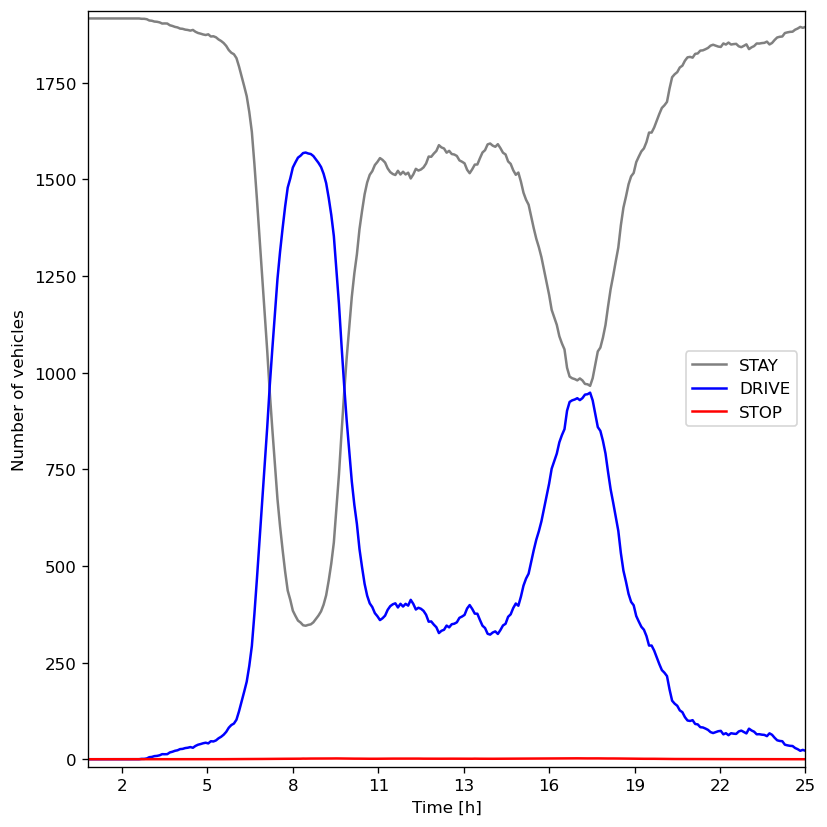

Fig. 1: Vehicle operations over the whole day with 1916 taxis with 4 places


In [51]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_task_time_profiles_drt["time_in_s"], df_task_time_profiles_drt["STAY"], color = "gray", label = "STAY")
plt.plot(df_task_time_profiles_drt["time_in_s"], df_task_time_profiles_drt["DRIVE"], color = "blue", label = "DRIVE")#, linestyle = ":")
plt.plot(df_task_time_profiles_drt["time_in_s"], df_task_time_profiles_drt["STOP"], color = "red", label = "STOP")#, linestyle = ":")

plt.xlabel("Time [h]")
plt.ylabel("Number of vehicles")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc3/task_time_profiles_drt_15_p_cent.pdf')
plt.close()
print("Fig. 1: Vehicle operations over the whole day with 1916 taxis with 4 places")

In [52]:
print("The max used vehicles is: ", int(max(df_task_time_profiles_drt["DRIVE"])))
print("Soit ", max(df_task_time_profiles_drt["DRIVE"])/1916 * 100, "% de la flotte.")

The max used vehicles is:  1569
Soit  81.89370215727209 % de la flotte.


**Analyses**


La figures *Fig. 1* montre la dynamique de répartition des taxis au cours de la journée respectivement pour une fotte de 1916 :
- L'utilisation des DRT fait bien ressortir les pics d'uttilisation des taxis durant les heures de pointes du matin (8h-9h) et du soir (17h-19h). Tous les vehicules ne sont pas utilisés. On note une exploitation de $\mathbf{81,90\%}$ de la flotte.
- On note egalement que moins de véhicules sont utilisés pendant la pointe de l'après-midi, car les trajets à vide sont plus courts. Cette situation est due probablement aux déplacments professionnels où les taxis sont utilisés le matin et parckés à proximités du lieu de travail.

In [53]:
df_task_time_profiles_drt["STAY_NORM"] = (df_task_time_profiles_drt["STAY"] - df_task_time_profiles_drt["STAY"].min()) / (df_task_time_profiles_drt["STAY"].max() - df_task_time_profiles_drt["STAY"].min())

## Daily statistics of taxis after the 1000th iteration

### Passenger Wait Time [s]

In [54]:
passenger_wait_time_file = "%s/ITERS/it.2000/sce3.v2.2000.waitStats_drt.csv" %output_path

In [55]:
df_passenger_wait_time = pd.read_csv(passenger_wait_time_file, sep=";")

In [56]:
df_passenger_wait_time

,timebin,legs,average_wait,min,p_5,p_25,median,p_75,p_95,max
0,03:00:00,1,126.00,126,126.00,126.00,126.0,126.00,126.00,126
1,03:30:00,22,242.86,2,8.00,75.25,192.5,321.75,763.25,788
2,04:00:00,52,209.77,2,2.00,100.25,172.5,318.50,562.15,633
3,04:30:00,87,257.20,2,42.40,110.00,188.0,345.00,673.80,816
4,05:00:00,113,306.12,2,41.20,139.00,251.0,454.00,652.40,929
5,05:30:00,175,271.60,2,48.40,133.00,219.0,365.00,645.40,706
6,06:00:00,324,304.12,2,44.50,125.00,242.5,448.00,754.25,1081
7,06:30:00,730,523.14,2,84.55,217.50,450.5,723.00,1247.90,2392
8,07:00:00,1352,1676.54,2,279.00,698.00,1080.5,2099.75,5340.40,8574
9,07:30:00,1796,2738.75,2,468.00,1012.50,1441.5,2739.75,11659.65,16337


In [57]:
df_passenger_wait_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timebin       51 non-null     object 
 1   legs          51 non-null     int64  
 2   average_wait  51 non-null     float64
 3   min           51 non-null     int64  
 4   p_5           51 non-null     float64
 5   p_25          51 non-null     float64
 6   median        51 non-null     float64
 7   p_75          51 non-null     float64
 8   p_95          51 non-null     float64
 9   max           51 non-null     int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 4.1+ KB


In [58]:
df_passenger_wait_time["average_wait"].unique()

array([ 126.  ,  242.86,  209.77,  257.2 ,  306.12,  271.6 ,  304.12,
        523.14, 1676.54, 2738.75, 2132.71, 1884.84, 1175.2 ,  495.9 ,
        287.7 ,  244.92,  243.04,  257.04,  265.66,  263.14,  255.47,
        284.36,  279.43,  280.86,  273.8 ,  284.97,  339.52,  396.63,
        448.93,  449.78,  405.83,  339.05,  292.93,  278.9 ,  248.95,
        228.07,  198.86,  194.32,  200.86,  210.69,  202.38,  229.82,
        208.15,  183.68,  159.37,  142.27,  119.52,  227.56,  117.73,
         44.33,   22.25])

In [59]:
df_passenger_wait_time["time_in_s"] = df_passenger_wait_time["timebin"].apply(convert_time_h_m_s).astype(float)

In [60]:
df_passenger_wait_time

,timebin,legs,average_wait,min,p_5,p_25,median,p_75,p_95,max,time_in_s
0,03:00:00,1,126.00,126,126.00,126.00,126.0,126.00,126.00,126,10800.0
1,03:30:00,22,242.86,2,8.00,75.25,192.5,321.75,763.25,788,12600.0
2,04:00:00,52,209.77,2,2.00,100.25,172.5,318.50,562.15,633,14400.0
3,04:30:00,87,257.20,2,42.40,110.00,188.0,345.00,673.80,816,16200.0
4,05:00:00,113,306.12,2,41.20,139.00,251.0,454.00,652.40,929,18000.0
5,05:30:00,175,271.60,2,48.40,133.00,219.0,365.00,645.40,706,19800.0
6,06:00:00,324,304.12,2,44.50,125.00,242.5,448.00,754.25,1081,21600.0
7,06:30:00,730,523.14,2,84.55,217.50,450.5,723.00,1247.90,2392,23400.0
8,07:00:00,1352,1676.54,2,279.00,698.00,1080.5,2099.75,5340.40,8574,25200.0
9,07:30:00,1796,2738.75,2,468.00,1012.50,1441.5,2739.75,11659.65,16337,27000.0


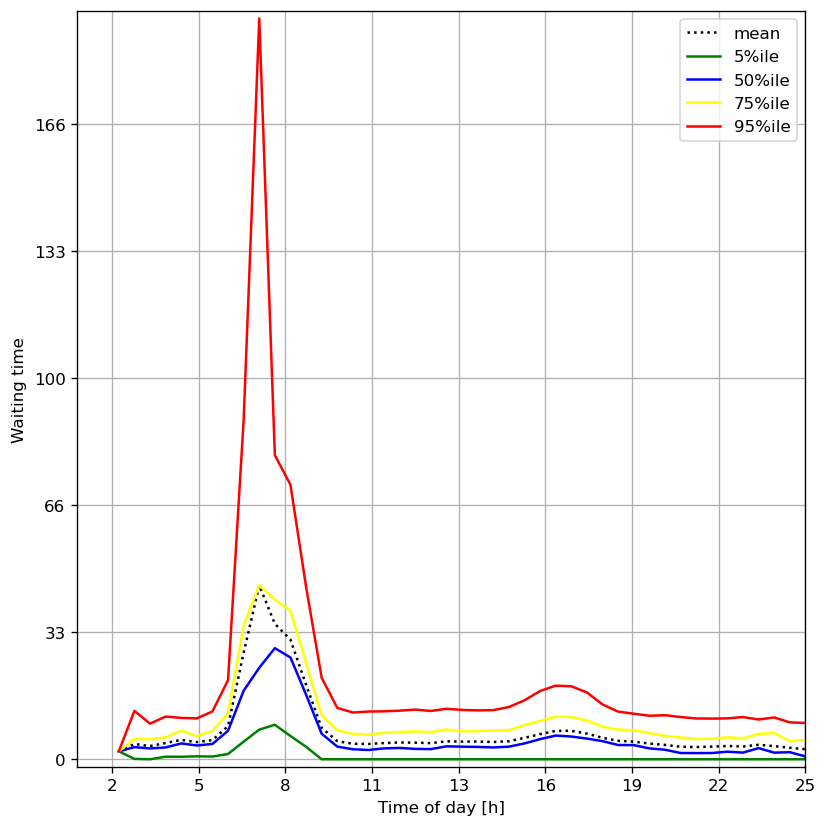

In [61]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["average_wait"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["p_5"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["median"], color = "blue", label = "50%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["p_75"], color = "yellow", label = "75%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["p_95"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc3/passenger_wait_time_15_p_cent.pdf', bbox_inches="tight")
plt.close()

In [62]:
print("Max temp 95%ile d'attente ", max(df_passenger_wait_time["p_95"])/60, " min")
print("Max temp moyen d'attente ", max(df_passenger_wait_time["average_wait"])/60, " min")
print("Max temp median d'attente ", max(df_passenger_wait_time["median"])/60, " min")
print("Max temp 5%ile d'attente ", max(df_passenger_wait_time["p_5"])/60, " min")

Max temp 95%ile d'attente  194.3275  min
Max temp moyen d'attente  45.645833333333336  min
Max temp median d'attente  29.175  min
Max temp 5%ile d'attente  9.075833333333332  min


**Commentaires**


La figure donne les temps d'attente moyen (noir en pointillé), median (bleu), 5%ile (vert) et 95%ile (rouge) au cours de la journée :
- Le **temps d'attente moyen** avoisine les $\mathbf{42}$ min pendant le pic du matin (vers 8h), tandisque le **95e percentile** depasse les **deux heures**. 
- Le reste de la journée, les agents attendent moins d'une quizaine de minutes en moyenne (seuil de tolerence). 

In [63]:
df_passenger_wait_time["avg_norm"] = (df_passenger_wait_time["average_wait"] - df_passenger_wait_time["average_wait"].min()) / (df_passenger_wait_time["average_wait"].max() - df_passenger_wait_time["average_wait"].min())

## waiting time vs idle vehicles

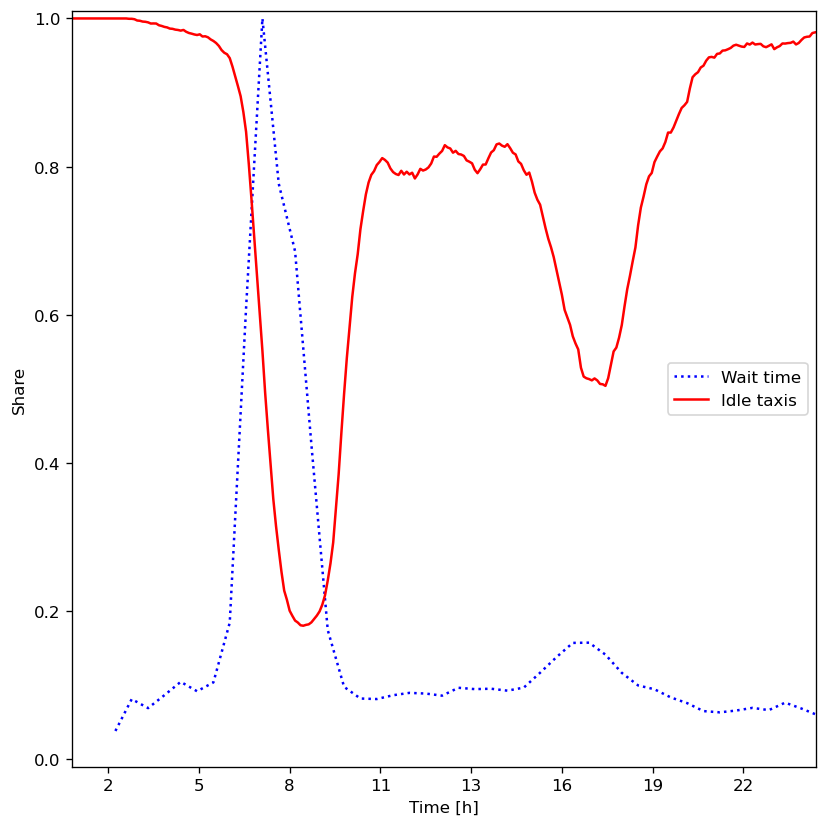

In [64]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["time_in_s"], df_passenger_wait_time["avg_norm"], color = "blue", label = "Wait time", linestyle = ":")
plt.plot(df_task_time_profiles_drt["time_in_s"], df_task_time_profiles_drt["STAY_NORM"], color = "red", label = "Idle taxis")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Share")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 88000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
#plt.show()
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc3/wainting_time_vs_idle_taxis_15_p_cent_sc3.pdf', bbox_inches="tight")
plt.close()

### Vehicle occupancy

In [65]:
vehicle_occup_file = "%s/ITERS/it.2000/sce3.v2.2000.occupancy_time_profiles_drt.txt" %output_path

In [66]:
df_vehicle_occup = pd.read_csv(vehicle_occup_file, sep="	")
df_vehicle_occup

,time,STAY,0 pax,1 pax,2 pax,3 pax,4 pax
0,00:00,1916.0,0.0,0.0,0.0,0.0,0.0
1,00:05,1916.0,0.0,0.0,0.0,0.0,0.0
2,00:10,1916.0,0.0,0.0,0.0,0.0,0.0
3,00:15,1916.0,0.0,0.0,0.0,0.0,0.0
4,00:20,1916.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
356,29:40,1916.0,0.0,0.0,0.0,0.0,0.0
357,29:45,1916.0,0.0,0.0,0.0,0.0,0.0
358,29:50,1916.0,0.0,0.0,0.0,0.0,0.0
359,29:55,1916.0,0.0,0.0,0.0,0.0,0.0


In [67]:
df_vehicle_occup["time_in_s"] = df_vehicle_occup["time"].apply(convert_time).astype(float)

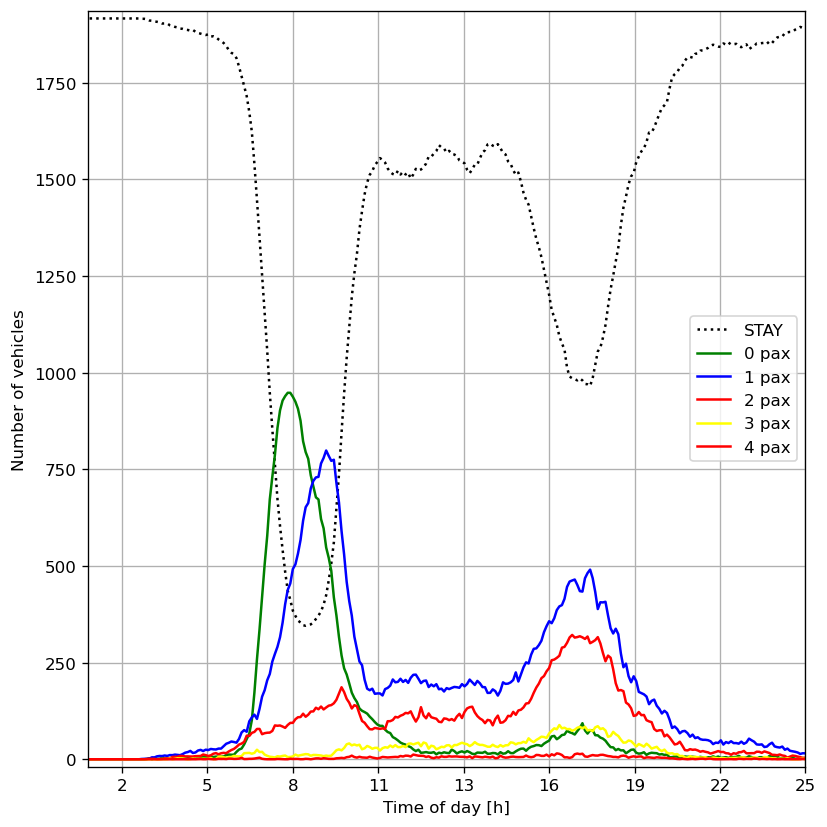

In [68]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["STAY"], color = "black", label = "STAY", linestyle = ":")
plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["0 pax"], color = "green", label = "0 pax")#, linestyle = ":")
plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["1 pax"], color = "blue", label = "1 pax")#, linestyle = ":")
plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["2 pax"], color = "red", label = "2 pax")#, linestyle = ":")
plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["3 pax"], color = "yellow", label = "3 pax")#, linestyle = ":")
plt.plot(df_vehicle_occup["time_in_s"], df_vehicle_occup["4 pax"], color = "red", label = "4 pax")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Number of vehicles")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc3/df_vehicle_occup_15_p_cent.pdf', bbox_inches="tight")
plt.close()

## Output trips cvs analysis

In [69]:
trips_file = "%s/sce3.v2.output_trips.csv.gz" %output_path
df_trips_output = pd.read_csv(gzip.open(trips_file,'r'), sep=";")

In [70]:
df_trips_output

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,1000008,1,1000008_1,07:03:47,00:24:24,00:05:09,2605,2193,NaN,pt,...,home_474430,8102,844783.995555,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,32123.link:pt_32123,32113.link:pt_32113
1,1000008,2,1000008_2,07:28:11,00:29:55,00:01:52,8913,7331,NaN,pt,...,sec_27677,50655,842728.100000,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,166.link:11588,30528.link:51396
2,1000008,3,1000008_3,12:03:47,00:10:16,00:00:00,740,569,NaN,walk,...,work_263614,51370,841768.160000,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN
3,1000008,4,1000008_4,12:33:47,00:10:16,00:00:00,740,569,NaN,walk,...,sec_45586,32552,841455.790000,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
4,1000008,5,1000008_5,17:33:47,00:48:58,00:14:01,11849,8580,NaN,pt,...,work_263614,51370,841768.160000,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,30529.link:51389,32122.link:pt_32122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230995,999994,2,999994_2,07:13:44,00:03:25,00:00:00,1470,802,NaN,car,...,sec_42480,69858,847968.600000,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN
230996,999994,3,999994_3,17:16:35,00:20:06,00:00:00,11045,7480,NaN,car,...,edu_1135,33122,847319.700000,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN
230997,999995,1,999995_1,07:33:22,00:08:43,00:00:00,3656,2768,NaN,car,...,home_474420,17018,854492.550000,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN
230998,999995,2,999995_2,11:38:27,00:09:36,00:00:00,3719,2768,NaN,car,...,edu_1164,44221,857259.400000,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN


In [71]:
df_trips_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231000 entries, 0 to 230999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person                  231000 non-null  int64  
 1   trip_number             231000 non-null  int64  
 2   trip_id                 231000 non-null  object 
 3   dep_time                231000 non-null  object 
 4   trav_time               231000 non-null  object 
 5   wait_time               231000 non-null  object 
 6   traveled_distance       231000 non-null  int64  
 7   euclidean_distance      231000 non-null  int64  
 8   main_mode               0 non-null       float64
 9   longest_distance_mode   231000 non-null  object 
 10  modes                   231000 non-null  object 
 11  start_activity_type     231000 non-null  object 
 12  end_activity_type       231000 non-null  object 
 13  start_facility_id       231000 non-null  object 
 14  start_link          

In [72]:
df_trips_output["dep_time_in_s"] = df_trips_output["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["trav_time_in_s"] = df_trips_output["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["wait_time_in_s"] = df_trips_output["wait_time"].apply(convert_time_h_m_s).astype(float)

### Parts modales

In [73]:
modal_share_out = df_trips_output["longest_distance_mode"].value_counts(normalize=True) * 100

In [74]:
modal_share_out

car              26.292641
pt               25.167965
walk             23.966667
drt              19.086580
car_passenger     5.209091
bike              0.277056
Name: longest_distance_mode, dtype: float64

Text(0.5, 0, 'Mode de transport')

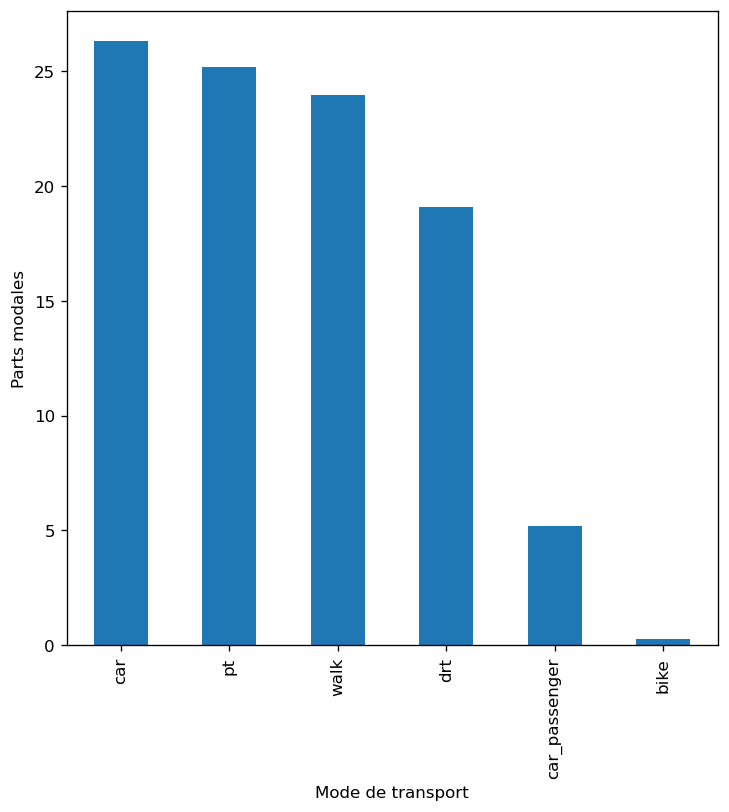

In [75]:
plt.figure(figsize = (7, 7), dpi = 120)
modal_share_out.plot(kind="bar")
plt.ylabel("Parts modales")
plt.xlabel("Mode de transport")

In [76]:
df_trips_output["dep_time_class"] = np.digitize(df_trips_output["dep_time_in_s"], time_class)

In [77]:
df_trips_output_drt = df_trips_output[df_trips_output["longest_distance_mode"]=="drt"]
df_trips_output_drt

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class
9,1000009,3,1000009_3,20:24:38,00:04:27,00:01:42,1355,556,NaN,drt,...,sec_17516,18634,844413.600000,6.520347e+06,NaN,NaN,73478.0,267.0,102.0,21
10,1000009,4,1000009_4,20:29:05,00:14:06,00:11:33,1240,556,NaN,drt,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,73745.0,846.0,693.0,21
11,1000010,1,1000010_1,07:55:40,00:58:16,00:39:03,3690,2522,NaN,drt,...,sec_22644,15949,847012.540000,6.518749e+06,NaN,NaN,28540.0,3496.0,2343.0,8
12,1000010,2,1000010_2,08:53:56,00:35:08,00:17:51,3741,2522,NaN,drt,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,32036.0,2108.0,1071.0,9
18,1000010,8,1000010_8,13:21:15,00:14:26,00:04:18,4041,1471,NaN,drt,...,sec_29607,87519,843383.300000,6.520382e+06,NaN,NaN,48075.0,866.0,258.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230970,99976,4,99976_4,22:55:59,00:15:54,00:00:37,4658,2890,NaN,drt,...,home_47634,83201,847706.800000,6.519676e+06,NaN,NaN,82559.0,954.0,37.0,23
230973,999796,3,999796_3,10:50:41,00:11:21,00:03:30,1473,667,NaN,drt,...,sec_26968,44071,847396.700000,6.512305e+06,NaN,NaN,39041.0,681.0,210.0,11
230974,999796,4,999796_4,11:37:10,00:12:06,00:00:02,2284,667,NaN,drt,...,home_474316,44297,847340.650000,6.512970e+06,NaN,NaN,41830.0,726.0,2.0,12
230975,999871,1,999871_1,08:43:59,01:01:37,00:30:45,4101,2658,NaN,drt,...,work_153947,27146,844019.770000,6.517061e+06,NaN,NaN,31439.0,3697.0,1845.0,9


Text(0.5, 0, 'Time of day [h]')

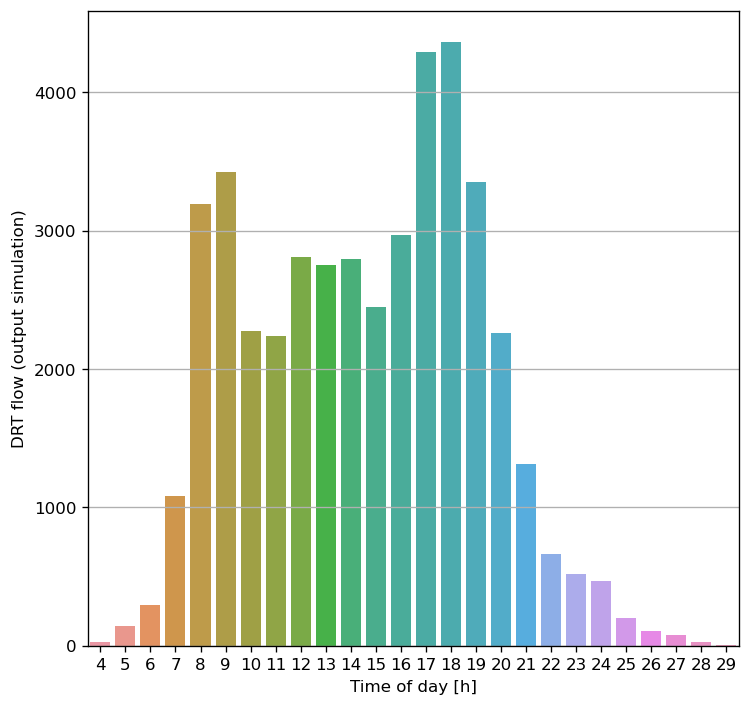

In [78]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_drt)
ax.grid(axis='y')
plt.ylabel("DRT flow (output simulation)")
plt.xlabel("Time of day [h]")

In [79]:
modal_share_inp

walk             57.289431
pt               17.425086
drt              10.374956
car               9.824156
car_passenger     3.693718
bike              1.392653
Name: mode, dtype: float64

In [80]:
modal_share_out

car              26.292641
pt               25.167965
walk             23.966667
drt              19.086580
car_passenger     5.209091
bike              0.277056
Name: longest_distance_mode, dtype: float64

**Commentaire**

- Le nombre total de déplacements en DRT passe de $\mathbf{10.8\%}$ (demande initiale) à $\mathbf{20.21\%}$ soit une augmentation de $\mathbf{87,12\%}$. Cette augmentation se traduit par une diminution des déplacements à pied ($- \mathbf{52\%}$ ) et à vélo ($- \mathbf{78,70\%}$ ) au profit des déplacements en PAV.
- La part modal en TC connait également une augmentation de $ \mathbf{37.49\%}$.

## Ouput event analysis

In [81]:
tree_events = ET.parse(gzip.open("%s/sce3.v2.output_events.xml.gz" % output_path,'r'))
events  = tree_events.getroot()

In [82]:
#rdvrpTaskStarted
time = []
person = []
link = []
dvrpVehicle = []
taskType = []

In [83]:
for event in events.iter('event'):
    if event.attrib["type"]=="dvrpTaskStarted":
        time.append(event.attrib["time"])
        person.append(event.attrib["person"])
        link.append(event.attrib["link"])
        dvrpVehicle.append(event.attrib["dvrpVehicle"])
        taskType.append(event.attrib["taskType"])

In [84]:
df_taskType = pd.DataFrame({"time":time, "person":person, "link": link, "dvrpVehicle" : dvrpVehicle, "taskType" : taskType})

df_taskType.to_csv("%s/df_taskType_drt.csv" % output_path)

In [85]:
df_taskType

,time,person,link,dvrpVehicle,taskType
0,0.0,TAX8040,12353,TAX8040,STAY
1,0.0,TAX2021,85928,TAX2021,STAY
2,0.0,TAX7082,1820,TAX7082,STAY
3,0.0,TAX2023,85928,TAX2023,STAY
4,0.0,TAX2064,69292,TAX2064,STAY
...,...,...,...,...,...
183423,102285.0,TAXVIL091165,82194,TAXVIL091165,DRIVE
183424,102545.0,TAX3081242,41451,TAX3081242,STOP
183425,102546.0,TAX3081242,41451,TAX3081242,STAY
183426,102938.0,TAXVIL091165,58222,TAXVIL091165,STOP


In [86]:
df_taskType_drive= df_taskType[df_taskType["taskType"]=="DRIVE"]

df_nb_drive_vh = df_taskType_drive.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_drive")

df_nb_drive_vh

,dvrpVehicle,number_of_drive
0,TAX1001057,75
1,TAX1001423,55
2,TAX1001641,41
3,TAX1001658,72
4,TAX1001734,73
...,...,...
1597,TAXVIL111879,43
1598,TAXVIL11282,41
1599,TAXVIL11470,68
1600,TAXVIL1182,52
